OBJECTIVE 6:	WAP to train and evaluate a Recurrent Neural Network using PyTorch Library to predict the next value in a sample time series dataset. 

Epoch 10/50, Loss: 0.0226
Epoch 20/50, Loss: 0.0225
Epoch 30/50, Loss: 0.0193
Epoch 40/50, Loss: 0.0166
Epoch 50/50, Loss: 0.0144

  Actual   |  Predicted  
-------------------------
     14.30 |        12.32
     17.40 |        12.30
     18.50 |        13.04
     16.80 |        13.67
     11.50 |        13.44
      9.50 |        11.98
     12.20 |        10.82
     15.70 |        11.16
     16.30 |        12.34
     13.60 |        12.96
     12.60 |        12.42
     13.80 |        11.84
     12.10 |        11.96
     13.40 |        11.71
     17.30 |        11.83
     19.40 |        12.89
     16.60 |        13.87
     13.90 |        13.50
     13.10 |        12.53
     16.00 |        11.98
     14.50 |        12.55
     15.00 |        12.56
     12.60 |        12.53
     12.50 |        11.99
     15.20 |        11.68
     16.20 |        12.28
     16.50 |        12.86
     20.10 |        13.08
     20.60 |        13.95
     16.90 |        14.49
     16.50 |        13.72
     16.10 

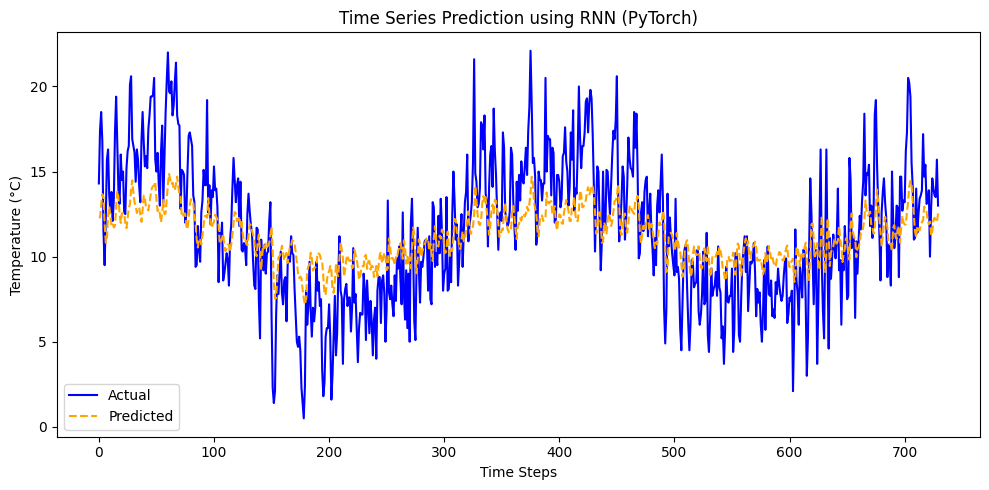

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv",
                 parse_dates=['Date'], index_col='Date')
data = df.values.astype('float32')

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 4
X, y = create_sequences(data_scaled, seq_length)

# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape for RNN input: [batch, seq, features]
X_train = X_train.view(X_train.size(0), seq_length, 1)
X_test = X_test.view(X_test.size(0), seq_length, 1)

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out

# Initialize model, loss, optimizer
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Inverse scale predictions and actual values
predicted = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.numpy())

# Print formatted Actual vs Predicted
print("\n{:^10s} | {:^12s}".format("Actual", "Predicted"))
print("-" * 25)
for actual_val, pred_val in zip(actual.flatten(), predicted.flatten()):
    print("{:10.2f} | {:12.2f}".format(actual_val, pred_val))

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual', color='blue')
plt.plot(predicted, label='Predicted', linestyle='dashed', color='orange')
plt.title("Time Series Prediction using RNN (PyTorch)")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()
